导入库，读入数据，定义lsb隐写的基本函数

In [57]:
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image as Image
import random
from scipy.stats import chi2

# 读取图片的像素信息
car_picture = Image.open('carrier.png').convert('L')
# picture = Image.open('carrier.png') #可以实现三通道彩色图lsb隐写

pic_data = np.array(car_picture)
gray_im = Image.fromarray(pic_data)
gray_im.save('grey_carrier.png')

# 读取要隐写的文件
with open('secret.txt', encoding="utf-8") as file:
    secrets = file.read()

def cover_lsb(bin_index, data_i_bin):
    '''
    :param bin_index:  当前字符的ascii的二进制
    :param data_i_bin: 取出隐写像素的八个数值
    :return: LSB隐写后的像素值
    '''
    if bin_index == '0':
        data_i_bin = data_i_bin[0:7] + '0'
    elif bin_index == '1':
        data_i_bin = data_i_bin[0:7] + '1'
    return data_i_bin

def lsb_decode(data):
    str = ''
    for i in range(len(data)):
        data_i_bin = bin(data[i])[2:][-1]
        str += data_i_bin
    return str

使用一般LSB隐写

In [76]:
#lsb加密
portion = 0.5 # 此处设置嵌入率
im_data = np.array(car_picture.copy()).ravel().tolist()
pic_idx = 0
#横向取数据，每次取8个数据，改变8个像素最低位
res_data = []
num = int(portion*len(im_data)/(8*len(secrets))) #按照嵌入率循环嵌入秘密文件的轮数
for i in range(num):
    for j in range(len(secrets)):
        # 拿到隐写文件的字符ascii数值, 并转换为二进制,填充成八位
        index = ord(secrets[j])
        bin_index = bin(index)[2:].zfill(8)
        # 对数据进行LSB隐写，替换操作
        res = []
        for k in range(8):
            data_i_bin = bin(im_data[pic_idx * 8 + k])[2:].zfill(8)
            res.append(int(cover_lsb(bin_index[k], data_i_bin),2))
        pic_idx += 1
        res_data += res
# 对剩余未填充的数据进行补充填充，防止图像无法恢复
res_data += im_data[pic_idx * 8:]

# 将新生成的文件进行格式转换并保存，此处一定保存为不压缩的png文件
new_im_data = np.array(res_data).astype(np.uint8).reshape((pic_data.shape))
res_im = Image.fromarray(new_im_data)
res_im.save('res_encode.png')

In [ ]:
# lsb解密
# 打开隐写文件
picture = Image.open('res_encode.png')
pic_datas = np.array(picture).ravel().tolist()

# 字符的长度为4893
with open('secret.txt', encoding="utf-8") as file:
    secrets = file.read()

str_len = len(secrets)
print('字符的长度为：', str_len)

# 将图片拷贝一份，作为最终的图片数据
im_data = np.array(picture.copy()).ravel().tolist()

pic_idx = 0
# 采用LSB隐写技术，横向取数据，每次取9个数据，改变8个像素最低位
res_data = []
for j in range(num):
    for i in range(len(secrets)):
        # 拿到第i个数据,转换成二进制
        data = im_data[(pic_idx+i) * 8: (pic_idx + i + 1) * 8]
        data_int = lsb_decode(data)
        # 找到最低位
        res_data.append(int(data_int, 2))

# 将二进制数据转换成ASCII
str_data = ''
for i in res_data:
    temp = chr(i)
    str_data += temp
print(str_data)

改进LSB（随机LSB）

In [74]:
#lsb加密
module = 2 #随机嵌入的模数
random.seed(2156)

im_data = np.array(car_picture.copy()).ravel().tolist()
pic_idx = 0
# 采用LSB隐写技术，横向取数据，每次取8个数据，改变8个像素最低位
res_data = []
portion = 1/module # 嵌入率
num = int(portion*len(im_data)/(8*len(secrets)))
for i in range(num):
    for j in range(len(secrets)):
        # 拿到隐写文件的字符ascii数值, 并转换为二进制,填充成八位
        index = ord(secrets[j])
        bin_index = bin(index)[2:].zfill(8)

        temp = random.sample(range(0 , 8 * module), 8)
        # 对数据进行LSB隐写，替换操作

        for k in range(8):
            data_i_bin = bin(im_data[pic_idx * 8 * module + temp[k]])[2:].zfill(8)
            data_i_bin = cover_lsb(bin_index[k], data_i_bin)
            im_data[pic_idx * 8 * module + temp[k]] = (int(data_i_bin, 2))

        pic_idx += 1

# 将新生成的文件进行格式转换并保存，此处一定保存为不压缩的png文件
new_im_data = np.array(im_data).astype(np.uint8).reshape((pic_data.shape))
res_im = Image.fromarray(new_im_data)
res_im.save('res_encode.png')

In [ ]:
# lsb解密
random.seed(2156)

# 打开隐写文件
picture = Image.open('res_encode.png')
pic_datas = np.array(picture.copy()).ravel().tolist()

# 字符的长度为4893
with open('secret.txt', encoding="utf-8") as file:
    secrets = file.read()

str_len = len(secrets)
print('字符的长度为：', str_len)

pic_idx = 0
# 采用LSB隐写技术，横向取数据，每次取9个数据，改变8个像素最低位
res_data = []
# module = 2 #随机嵌入的模数
# portion = 1/module # 嵌入率
# num = int(portion*len(im_data)/(8*str_len))

for j in range(num):
    for i in range(len(secrets)):
        # 拿到第i个数据,转换成二进制
        temp = random.sample(range(0, 8 * module), 8)
        # 对数据进行LSB隐写，替换操作
        temp_data = []
        for k in range(8):
            temp_data.append(pic_datas[pic_idx * 8 * module + temp[k]])
        data_int = lsb_decode(temp_data)
        pic_idx += 1
        # 找到最低位
        res_data.append(int(data_int, 2))

# 将二进制数据转换成ASCII
str_data = ''
for i in res_data:
    temp = chr(i)
    str_data += temp
print(str_data)

灰度直方图对比，以及基于卡方的隐写分析

载体图像的r值：555.9948149299776,	 p值：0.0
隐写图像的r值：272.1792349566527,	 p值：1.3385959007905512e-12


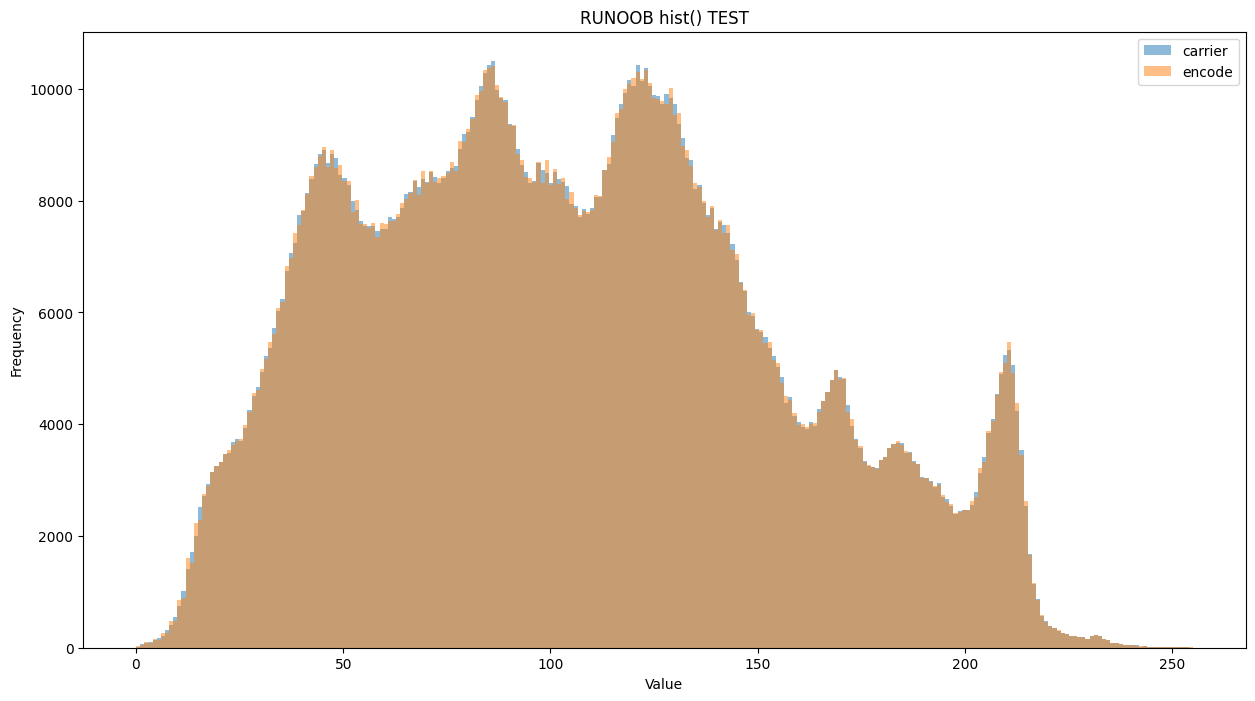

In [77]:
# 读取图片的像素信息
picture_ = Image.open('res_encode.png')

pic_data_ = np.array(picture_)
im_data = np.array(car_picture.copy())
kwargs = dict(alpha=0.5, bins=256)
plt.figure(figsize=(15, 8))
n1,bins1,patches1 = plt.hist(im_data.ravel(), **kwargs);
n2,bins2,patches2 = plt.hist(pic_data_.ravel(), **kwargs);
plt.title('RUNOOB hist() TEST')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend(["carrier", "encode"])

def cal_rp(data_list):
    r = 0
    for i in range(0,256,2):
        h2i = (data_list[i]+data_list[i+1])/2
        r += ((data_list[i]-h2i)**2)/h2i
    p = 1.0 - chi2.cdf(r,127)
    return r, p

r1, p1 = cal_rp(n1)
r2, p2 = cal_rp(n2)
print("载体图像的r值："+str(r1)+",\t p值："+str(p1))
print("隐写图像的r值："+str(r2)+",\t p值："+str(p2))